In [10]:
import pandas as pd
import os
import glob
from tqdm import tqdm

## Create Dataset (Only run when datasets are changed)

In [17]:
disorder_texts = []
for expurgated_data_path in glob.glob('../Data/Expurgated_Data/Reddit/*'):
    #file_name = expurgated_data_path.split('/')[-1].split('.')[0]
    disorder_df = pd.read_excel(expurgated_data_path)
    disorder_texts.extend(disorder_df['Translated_Text'].values)

disorder_df = pd.DataFrame({
    "Text": disorder_texts,
    "Label": "Disorder"
})

disorder_df.head()

,Text,Label
0,"Sıkışmış hissetmek (yerine tekrar giriş yok, y...",Disorder
1,Yakın zamanda başka bir şehre taşındım ve nele...,Disorder
2,"Panik atak geçirmenin eşiğindeydim, sadece bun...",Disorder
3,Geçen hafta maruz kalma terapimi yaparken soka...,Disorder
4,Bazen özgüven ve benlik imajıyla çok mücadele ...,Disorder


In [18]:
normal_data = pd.read_csv('../Data/Disorder_Detection_Datasets/normal_dataset_translated_chunk_1.csv')
normal_data.head()

,Text,Label,Translated_Text
0,So let's be clear here. I'm totally fine.\n\nI...,Normal,Yani burada açık olalım. Ben tamamen iyiyim. B...
1,"I’m a 35 year old man, the sole income of a ho...",Normal,"Ben 35 yaşında bir adamım, 3 kişilik bir evin ..."
2,My life is over I’m about to be 21 and I alrea...,Normal,Hayatım bitti 21 olmak üzereyim ve zaten ölü h...
3,I just want to outlet. I’m running out of opti...,Normal,Sadece çıkış yapmak istiyorum. Seçeneklerim tü...
4,Every time I start to feel depressed (It comes...,Normal,Ne zaman depresif hissetmeye başlasam (Dalgala...


In [21]:
total_df = pd.DataFrame()

total_df['Text'] = normal_data['Translated_Text']
total_df['Label'] = normal_data['Label']

total_df = pd.concat([total_df, disorder_df], axis=0).reset_index(drop=True)

In [23]:
total_df['Label'].value_counts()

Label
Disorder    8850
Normal      5000
Name: count, dtype: int64

In [24]:
total_df.to_excel('../Data/Disorder_Detection_Datasets/main_dataset.xlsx', index=False)
print("Saved")

Saved


## Start

In [59]:
import json
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import BertModel, BertTokenizer
import warnings
import numpy as np

warnings.filterwarnings('ignore')
# specify GPU
device = torch.device("cuda")
print(device)

cuda


In [28]:
df = pd.read_excel('../Data/Disorder_Detection_Datasets/main_dataset.xlsx')
df

,Text,Label
0,Yani burada açık olalım. Ben tamamen iyiyim. B...,Normal
1,"Ben 35 yaşında bir adamım, 3 kişilik bir evin ...",Normal
2,Hayatım bitti 21 olmak üzereyim ve zaten ölü h...,Normal
3,Sadece çıkış yapmak istiyorum. Seçeneklerim tü...,Normal
4,Ne zaman depresif hissetmeye başlasam (Dalgala...,Normal


In [45]:
df[df['Text'].isnull()]

,Text,Label
12966,NaN,Disorder


In [48]:
class LoadingData():
            
    def __init__(self, data_path):
        self.train = pd.read_excel(data_path)
        self.train.dropna(inplace=True)
        print("Data was read")

In [49]:
ld = LoadingData(data_path="../Data/Disorder_Detection_Datasets/main_dataset.xlsx")

Data was read


In [104]:
train_text, val_text, train_labels, val_labels = train_test_split(ld.train['Text'], ld.train['Label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify= ld.train['Label'])

In [105]:
tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-turkish-128k-uncased")
bert = BertModel.from_pretrained("dbmdz/bert-base-turkish-128k-uncased")

382


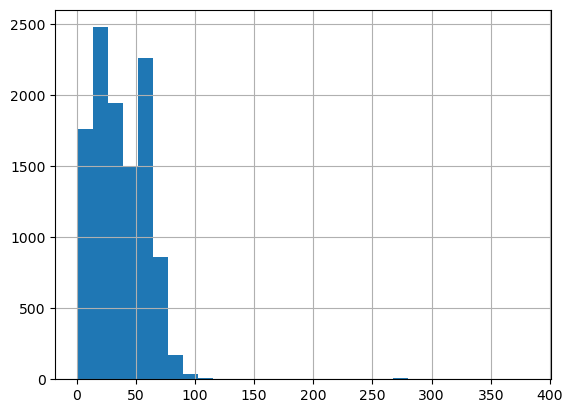

In [106]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)
max_seq_len = max(seq_len)
print(max_seq_len)

In [107]:
# tokenize and encode sequences in the training set
if max_seq_len>512:
    max_seq_len = 512
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [108]:
np.shape(train_labels.to_list())

(11079,)

In [109]:
train_labels

11421    Disorder
11896    Disorder
6813     Disorder
12246    Disorder
7993     Disorder
           ...   
3901       Normal
2986       Normal
7113     Disorder
11865    Disorder
13125    Disorder
Name: Label, Length: 11079, dtype: object

In [111]:
train_labels[train_labels == 'Disorder'] = 1
train_labels[train_labels == 'Normal'] = 0

val_labels[val_labels == 'Disorder'] = 1
val_labels[val_labels == 'Normal'] = 0

In [119]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.to_list())
print("train_y:",train_y)

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
print("val_y:",val_y)

train_y: tensor([1, 1, 1,  ..., 1, 1, 1])
val_y: tensor([1, 1, 1,  ..., 1, 1, 1])


In [121]:
train_y.shape

torch.Size([11079])

## Build Model Architecture

In [122]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16



# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)



# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [123]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [144]:
class Binary_BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(Binary_BERT_Arch, self).__init__()
        self.bert = bert 
      
        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512, 1)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)
        self.sigmoid = nn.Sigmoid()

        #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask)
        
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply sigmoid activation
        x = self.sigmoid(x)
        
        return x

In [146]:
# pass the pre-trained BERT to our define architecture
model = Binary_BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [126]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [127]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[1.384875   0.78252578]


In [128]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 100

In [135]:
# function to train the model
def train():
    model.train()

    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
    total_labels =[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
        # progress update after every 50 batches.
        if step % 100 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()
        preds = np.argmax(preds, axis=1)
        # append the model predictions
        total_preds+=list(preds)
        total_labels+=labels.tolist()

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    #total_preds  = np.concatenate(total_preds, axis=0)
    f1 = f1_score(total_labels, total_preds, average='weighted')
    #returns the loss and predictions
    return avg_loss, f1

In [136]:
# function for evaluating the model
def evaluate():
  
    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []
    total_labels = []
    # iterate over batches
    for step,batch in enumerate(val_dataloader):
    
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

          # Calculate elapsed time in minutes.
          #elapsed = format_time(time.time() - t0)

          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()
            preds = np.argmax(preds, axis=1)
            total_preds+=list(preds)
            total_labels+=labels.tolist()
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    #total_preds  = np.concatenate(total_preds, axis=0)
    
    f1 = f1_score(total_labels, total_preds, average='weighted')
    return avg_loss, f1

In [137]:
def save_checkpoint(filename, epoch, model, optimizer, label_map, id2label):
    state = {
        'epoch': epoch,
        'model': model,
        'optimizer': optimizer,
        'label_map': label_map,
        'id_map':id2label}
    torch.save(state, filename)

In [147]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, f1_train = train()
    
    #evaluate model
    valid_loss, f1_valid = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        file_name = 'disorder_detection_model.pt'
        save_checkpoint(file_name, epoch, model, optimizer, label_map, id2label)
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'\nTraining F1: {f1_train:.3f}')
    print(f'Validation F1: {f1_valid:.3f}')


 Epoch 1 / 100
pooler_output
last_hidden_state


TypeError: linear(): argument 'input' (position 1) must be Tensor, not str